In [ ]:
import os
import sys
import html
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/NLP_Assignment_2025(phase3)'
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
DATA_SAVE_PATH = os.path.join(PROJECT_PATH, 'data')

if not os.path.exists(CHECKPOINT_PATH): os.makedirs(CHECKPOINT_PATH)
if not os.path.exists(DATA_SAVE_PATH): os.makedirs(DATA_SAVE_PATH)

print(f"Phase 3 Setup Complete. Saving to: {PROJECT_PATH}")

!pip install -q pyvi spacy torchtext tokenizers
!python -m spacy download en_core_web_sm

Mounted at /content/drive
Phase 3 Setup Complete. Saving to: /content/drive/MyDrive/NLP_Assignment_2025(phase3)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 142.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import os
import tarfile
import sys

def download_real_data():
    data_dir = 'data'
    if not os.path.exists(data_dir): os.makedirs(data_dir)

    url = "https://github.com/stefan-it/nmt-en-vi/raw/master/data/train-en-vi.tgz"
    tgz_path = os.path.join(data_dir, "train-en-vi.tgz")
    expected_vi = os.path.join(data_dir, "train.vi")
    expected_en = os.path.join(data_dir, "train.en")

    if os.path.exists(expected_vi) and os.path.exists(expected_en):
        if os.path.getsize(expected_vi) > 0:
            print("Data already exists. Skipping download.")
            return

    print("Downloading data...")
    os.system(f"wget -q {url} -O {tgz_path}")

    print("Extracting data...")
    with tarfile.open(tgz_path, "r:gz") as tar:
        tar.extractall(path=data_dir)

    print(f"Data ready at: {data_dir}")

download_real_data()

Extracting data...


/tmp/ipython-input-1924179185.py:24: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=data_dir)


Data ready at: data


In [3]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_head == 0, "d_model must be divisible by n_head"
        self.d_head = d_model // n_head
        self.n_head = n_head
        self.d_model = d_model
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        Q = self.w_q(query).view(batch_size, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        K = self.w_k(key).view(batch_size, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        V = self.w_v(value).view(batch_size, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / math.sqrt(self.d_head)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e9)
        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(attention, V)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        return self.fc_out(x)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src, src_mask):
        _src = self.self_attn(src, src, src, src_mask)
        src = self.norm1(src + self.dropout(_src))
        _src = self.ffn(src)
        src = self.norm2(src + self.dropout(_src))
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.cross_attn = MultiHeadAttention(d_model, n_head)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, trg, enc_src, trg_mask, src_mask):
        _trg = self.self_attn(trg, trg, trg, trg_mask)
        trg = self.norm1(trg + self.dropout(_trg))
        _trg = self.cross_attn(trg, enc_src, enc_src, src_mask)
        trg = self.norm2(trg + self.dropout(_trg))
        _trg = self.ffn(trg)
        trg = self.norm3(trg + self.dropout(_trg))
        return trg

class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, n_layer, n_head, d_ff, dropout, max_len):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_head, d_ff, dropout) for _ in range(n_layer)])
        self.dropout = nn.Dropout(dropout)
    def forward(self, src, src_mask):
        src = self.dropout(self.pos_encoding(self.embedding(src)))
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

class Decoder(nn.Module):
    def __init__(self, output_dim, d_model, n_layer, n_head, d_ff, dropout, max_len):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_head, d_ff, dropout) for _ in range(n_layer)])
        self.fc_out = nn.Linear(d_model, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, trg, enc_src, trg_mask, src_mask):
        trg = self.dropout(self.pos_encoding(self.embedding(trg)))
        for layer in self.layers:
            trg = layer(trg, enc_src, trg_mask, src_mask)
        output = self.fc_out(trg)
        return output

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, d_model=256, n_head=8, n_layer=3, d_ff=512, dropout=0.1, max_len=100, src_pad_idx=1, trg_pad_idx=1):
        super(Transformer, self).__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.encoder = Encoder(src_vocab_size, d_model, n_layer, n_head, d_ff, dropout, max_len)
        self.decoder = Decoder(trg_vocab_size, d_model, n_layer, n_head, d_ff, dropout, max_len)
    def make_src_mask(self, src):
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=trg.device)).bool()
        return trg_pad_mask & trg_sub_mask
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        output = self.decoder(trg, enc_src, trg_mask, src_mask)
        return output

In [ ]:
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
import os
import html
from tqdm import tqdm

def clean_file(raw_path, clean_path):
    with open(raw_path, 'r', encoding='utf-8') as f_in, open(clean_path, 'w', encoding='utf-8') as f_out:
        for line in tqdm(f_in, desc=f"Cleaning {os.path.basename(raw_path)}"):
            clean_line = html.unescape(line).replace('\xa0', ' ').strip()
            if clean_line:
                f_out.write(clean_line + "\n")
    return clean_path

if not os.path.exists('data/clean_vi.txt'):
    clean_file('data/train.vi', 'data/clean_vi.txt')
if not os.path.exists('data/clean_en.txt'):
    clean_file('data/train.en', 'data/clean_en.txt')

print("Training Source Tokenizer (BPE)...")
src_tokenizer = ByteLevelBPETokenizer()
src_tokenizer.train(files=["data/clean_vi.txt"], vocab_size=10000, min_frequency=2, special_tokens=["<pad>", "<sos>", "<eos>", "<unk>"])
src_tokenizer.save_model(DATA_SAVE_PATH, "src_bpe")

print("Training Target Tokenizer (BPE)...")
trg_tokenizer = ByteLevelBPETokenizer()
trg_tokenizer.train(files=["data/clean_en.txt"], vocab_size=10000, min_frequency=2, special_tokens=["<pad>", "<sos>", "<eos>", "<unk>"])
trg_tokenizer.save_model(DATA_SAVE_PATH, "trg_bpe")

print("BPE Tokenizers Saved!")

Cleaning train.vi: 133317it [00:00, 171707.46it/s]
Cleaning train.en: 133317it [00:00, 253828.40it/s]


Training Source Tokenizer (BPE)...
Training Target Tokenizer (BPE)...
BPE Tokenizers Saved!


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import TemplateProcessing

# Load Tokenizer đã train
src_tokenizer = ByteLevelBPETokenizer(
    os.path.join(DATA_SAVE_PATH, "src_bpe-vocab.json"),
    os.path.join(DATA_SAVE_PATH, "src_bpe-merges.txt")
)
trg_tokenizer = ByteLevelBPETokenizer(
    os.path.join(DATA_SAVE_PATH, "trg_bpe-vocab.json"),
    os.path.join(DATA_SAVE_PATH, "trg_bpe-merges.txt")
)

src_tokenizer.post_processor = TemplateProcessing(
    single="<sos> $A <eos>",
    special_tokens=[("<sos>", 1), ("<eos>", 2)],
)
trg_tokenizer.post_processor = TemplateProcessing(
    single="<sos> $A <eos>",
    special_tokens=[("<sos>", 1), ("<eos>", 2)],
)
src_tokenizer.enable_padding(pad_id=0, pad_token="<pad>")
trg_tokenizer.enable_padding(pad_id=0, pad_token="<pad>")

class BPEDataset(Dataset):
    def __init__(self, src_file, trg_file, src_tok, trg_tok, max_len=150):
        self.src_data = []
        self.trg_data = []
        self.src_tok = src_tok
        self.trg_tok = trg_tok
        self.max_len = max_len

        print(f"Loading data from {src_file}...")
        with open(src_file, 'r', encoding='utf-8') as f: src_lines = f.readlines()
        with open(trg_file, 'r', encoding='utf-8') as f: trg_lines = f.readlines()

        for src, trg in zip(src_lines, trg_lines):
            self.src_data.append(src.strip())
            self.trg_data.append(trg.strip())

    def __len__(self): return len(self.src_data)

    def __getitem__(self, index):
        # Tokenizer encode
        src_encoded = self.src_tok.encode(self.src_data[index])
        trg_encoded = self.trg_tok.encode(self.trg_data[index])

        src_ids = torch.tensor(src_encoded.ids)
        trg_ids = torch.tensor(trg_encoded.ids)

        # Truncate nếu dài
        if len(src_ids) > self.max_len: src_ids = src_ids[:self.max_len]
        if len(trg_ids) > self.max_len: trg_ids = trg_ids[:self.max_len]

        return src_ids, trg_ids

def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src, trg in batch:
        src_batch.append(src)
        trg_batch.append(trg)

    src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=0, batch_first=True)
    trg_batch = torch.nn.utils.rnn.pad_sequence(trg_batch, padding_value=0, batch_first=True)
    return src_batch, trg_batch

train_dataset = BPEDataset('data/clean_vi.txt', 'data/clean_en.txt', src_tokenizer, trg_tokenizer)
train_iterator = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

Loading data from data/clean_vi.txt...


In [6]:
import torch.nn as nn

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = padding_idx

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = (target == self.padding_idx)
            if mask.any():
                true_dist.masked_fill_(mask.unsqueeze(1), 0.0)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000, factor=1.0):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.factor = factor
        self.step_num = 0
    def step(self):
        self.step_num += 1
        lr = self.factor * (self.d_model ** -0.5) * min(self.step_num ** -0.5, self.step_num * (self.warmup_steps ** -1.5))
        for p in self.optimizer.param_groups: p['lr'] = lr

def train_one_epoch(model, iterator, optimizer, criterion, clip, device, scheduler=None):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        trg_input = trg[:, :-1]
        trg_output = trg[:, 1:]
        optimizer.zero_grad()
        output = model(src, trg_input)
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg_output = trg_output.contiguous().view(-1)
        loss = criterion(output, trg_output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if scheduler: scheduler.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

Training on: cuda
Trainable parameters: 59,508,496
Starting Phase 3 Training (BPE + Base Model)...
Epoch: 01 | Time: 17.9m | Loss: 2.2235
  --> Saved Best Model
Epoch: 02 | Time: 17.9m | Loss: 2.1003
  --> Saved Best Model
Epoch: 03 | Time: 17.9m | Loss: 2.0489
  --> Saved Best Model
Epoch: 04 | Time: 17.9m | Loss: 2.0265
  --> Saved Best Model
Epoch: 05 | Time: 17.9m | Loss: 2.0026
  --> Saved Best Model
Epoch: 06 | Time: 17.9m | Loss: 1.9930
  --> Saved Best Model
Epoch: 07 | Time: 17.9m | Loss: 1.9876
  --> Saved Best Model
Epoch: 08 | Time: 17.9m | Loss: 1.9689
  --> Saved Best Model
Epoch: 09 | Time: 17.9m | Loss: 1.9593
  --> Saved Best Model
Epoch: 10 | Time: 17.9m | Loss: 1.9515
  --> Saved Best Model


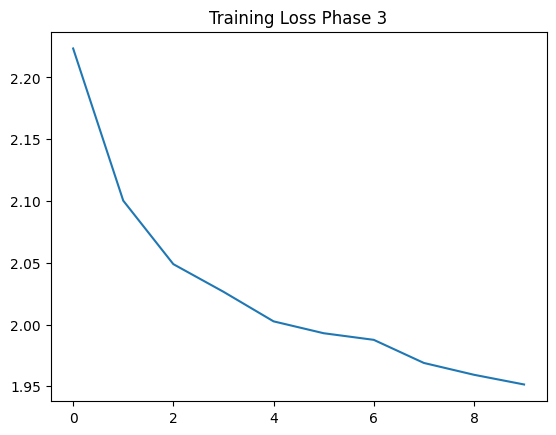

In [ ]:
import time
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {DEVICE}")

# Vocab size lấy từ BPE tokenizer
INPUT_DIM = src_tokenizer.get_vocab_size()
OUTPUT_DIM = trg_tokenizer.get_vocab_size()
PAD_IDX = 0 

D_MODEL = 512   
N_HEAD = 8       
N_LAYER = 6      
D_FF = 2048      
DROPOUT = 0.1
MAX_LEN = 150

model = Transformer(INPUT_DIM, OUTPUT_DIM, D_MODEL, N_HEAD, N_LAYER, D_FF, DROPOUT, MAX_LEN, PAD_IDX, PAD_IDX).to(DEVICE)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(initialize_weights)

print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)
scheduler = NoamScheduler(optimizer, d_model=D_MODEL, warmup_steps=4000)
criterion = LabelSmoothingLoss(classes=OUTPUT_DIM, padding_idx=PAD_IDX, smoothing=0.1)

N_EPOCHS = 10
CLIP = 1
train_losses = []
best_loss = float('inf')

print(f"Starting Phase 3 Training (BPE + Base Model)...")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train_one_epoch(model, train_iterator, optimizer, criterion, CLIP, DEVICE, scheduler)
    end_time = time.time()

    train_losses.append(train_loss)
    print(f'Epoch: {epoch+1:02} | Time: {(end_time-start_time)/60:.1f}m | Loss: {train_loss:.4f}')

    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_PATH, 'transformer_phase3_best.pt'))
        print("  --> Saved Best Model")

plt.plot(train_losses, label='Phase 3 (BPE + Base)')
plt.title('Training Loss Phase 3')
plt.savefig(os.path.join(PROJECT_PATH, 'loss_phase3.png'))
plt.show()